### Purpose of Notebook

Plot $\tilde{k}$ _vs._ $\overline{k}$, and $\tilde{t}$  _vs._ $\overline{t}$

In [13]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt
from matplotlib import rc

rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

from typing import Tuple,List, Dict, Callable

#path stuff
from pathlib import WindowsPath, PosixPath
import sys
PathPath = WindowsPath if 'win' in sys.platform.lower() else PosixPath
PARENT_DIR = PathPath('../')
DATA_DIR = PARENT_DIR.joinpath('rf_data')
MODEL_PATH = PARENT_DIR.joinpath('.model')
INFERENCE_PATH = PARENT_DIR.joinpath('.inference')  
GIT_IMAGE_PATH = PARENT_DIR.joinpath('.git_images')
sys.path.append(str(PARENT_DIR))

from common_util import setup_axis_default 
from numpyro.diagnostics import hpdi

import pickle



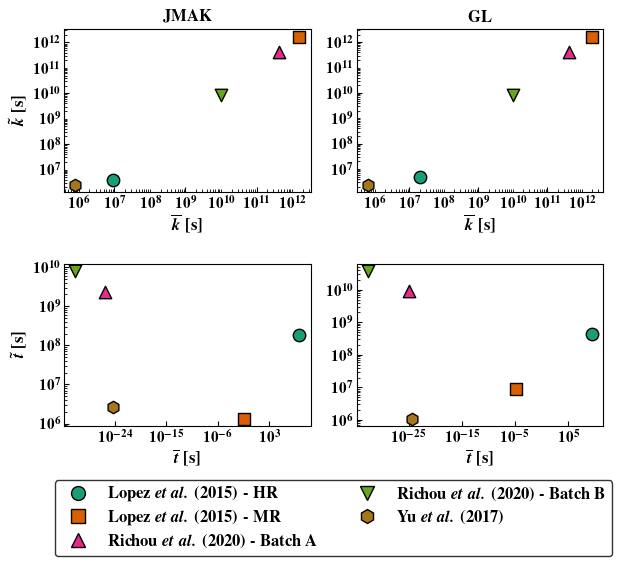

In [50]:
#path stuff
from pathlib import WindowsPath, PosixPath
import sys
PathPath = WindowsPath if 'win' in sys.platform.lower() else PosixPath
PARENT_DIR = PathPath('../')
DATA_DIR = PARENT_DIR.joinpath('rf_data')
INFERENCE_PATH = PARENT_DIR.joinpath('.inference')  
GIT_IMAGE_PATH = PARENT_DIR.joinpath('.git_images')
sys.path.append(str(PARENT_DIR))

from common_util import hdi, setup_axis_default,kbar_jmak,kbar_gl,tbar,_FILE_TO_LABEL as file_to_label
from statsmodels.regression.linear_model import OLS
import copy
import math
from typing import List
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib import rc
import warnings
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator


rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

def estimate_latent_model_params(samples: pd.DataFrame,
                                 ycols: List[str],
                                 xcols: List[str] = ['k_bar'],
                                 degree = 1,
                                 **kwargs) -> dict:
    
    models = dict.fromkeys(ycols)
    X = PolynomialFeatures(degree = degree,**kwargs).fit_transform(samples[xcols].to_numpy())
    for ycol in ycols:
        y = samples[ycol].to_numpy()
        ols = OLS(y,X).fit()
        models[ycol] = copy.deepcopy(ols)

    return models

#setup axis and formatting
fig,axes_ = plt.subplot_mosaic(""" AB
                                  CD
                                  EE""" ,figsize = (6.5,5.75),height_ratios= [1,1,0.25])

axes = np.array([axes_[key] for key in ['A','B','C','D']]).reshape([2,2])
lax = axes_['E']

colors = plt.get_cmap('Dark2')(np.linspace(0,1,len(file_to_label)))
titles = [r'\textbf{JMAK}',r'\textbf{GL}']
symbols = np.array(['o','s','^','v','h'])

for p,(model_name,title) in enumerate(zip(['JMAK_{}','Generalized Logistic_{}'],titles)):
    kbar = kbar_jmak if 'JMAK' in model_name else kbar_gl

    #somwewhat arbitrary temperature values
    T_1 = 800.0 + 273.15
    T_2 = 1300.0 + 273.15

    #strorage lists
    inference_results = {}
    total_samples = []

    #model parameters
    ep = 'n' if 'JMAK' in model_name else 'nu'
    model_params = ['a1','B1','a2','B2',ep]

    #hierarchical model
    with open(INFERENCE_PATH.joinpath(f'{model_name.format("hierarchical")}_trunc_normal_samples.pkl'),'rb') as f:
        posterior_samples = pickle.load(f)['latent_variables']
        posterior_samples = np.exp(posterior_samples)
        inf_summary = posterior_samples.mean(axis = 0)
        inf_summary_std = posterior_samples.std(axis = 0)


    confidence_intervals = {'kbar': np.empty([posterior_samples.shape[1],2]),
                            'tbar': np.empty([posterior_samples.shape[1],2])}
    """
    for k,lv in enumerate(['kbar','tbar']):
        for i in range(posterior_samples.shape[1]):
            for j,ci in enumerate(hpdi(posterior_samples[:,i,k],0.95)):
                confidence_intervals[lv][i][j] = ci
    """

    confidence_intervals['kbar'] = np.array([inf_summary[:,0] - 1.96*inf_summary_std[:,0],
                                             inf_summary[:,0] + 1.96*inf_summary_std[:,0]]).T
    confidence_intervals['tbar'] = np.array([inf_summary[:,1] - 1.96*inf_summary_std[:,1],
                                             inf_summary[:,1] + 1.96*inf_summary_std[:,1]]).T
    k_hier = pd.DataFrame(np.concatenate([inf_summary[:,0:1],confidence_intervals['kbar']],axis = 1),columns = ['ml','lower','upper'])
    t_hier = pd.DataFrame(np.concatenate([inf_summary[:,1:],confidence_intervals['tbar']],axis = 1),columns = ['ml','lower','upper'])

    k_sep = np.empty_like(k_hier)
    t_sep = np.empty_like(t_hier)

    for k,data_name in enumerate(list(file_to_label.values())[:-1]):

        #load the maximum likelihood estimates from a file
        ip = pd.read_csv(INFERENCE_PATH.joinpath(f'{model_name.format(data_name)}_trunc_normal_params.csv'),index_col = 0).T
        #calculate maximum likelihood of effective rate constant
        for row in ip.index:
            ip.loc[row,'k_bar'] = kbar(ip.loc[row,'a1'],ip.loc[row,'B1'],ip.loc[row,ep],T_1,T_2)
            ip.loc[row,'t_bar'] = tbar(ip.loc[row,'a2'],ip.loc[row,'B2'],T_1,T_2)

        #load the samples from a file
        with open(INFERENCE_PATH.joinpath(f'{model_name.format(data_name)}_trunc_normal_samples.pkl'),'rb') as f:
            samples = pd.DataFrame.from_dict(pickle.load(f)).iloc[::20]

        #compute the effective rate constant
        samples['k_bar'] = np.empty(samples.shape[0])
        samples['t_bar'] = np.empty(samples.shape[0])
        for row in samples.index:
            with warnings.catch_warnings(action = 'ignore'): 
                samples.loc[row,'k_bar']=  kbar(samples.loc[row,'a1'],samples.loc[row,'B1'],samples.loc[row,ep],T_1,T_2)
                samples.loc[row,'t_bar'] = tbar(samples.loc[row,'a2'],samples.loc[row,'B2'],T_1,T_2)
        
        samples.dropna(inplace= True)
        samples = samples.loc[~np.any(np.isinf(samples.to_numpy()),axis = 1),:]  
        ip.loc[['std'],'k_bar'] = samples['k_bar'].std()  
        ip.loc[['std'],'t_bar'] = samples['t_bar'].std()

        samples.drop('sigma',axis = 1,inplace = True)   

        #compute confidence intervals
        for j,col in enumerate(list(samples.columns)):
            ip.loc['lower',col] = ip.loc['mean',col] - 1.96*ip.loc['std',col]
            ip.loc['upper',col] = ip.loc['mean',col] + 1.96*ip.loc['std',col]
            #for label,ci in zip(['lower','upper'],hdi(samples[col].to_numpy(),0.95).squeeze()):
            #    ip.loc[label,col] = ci
        
        k_sep[k] = ip.loc[['mean','lower','upper'],['k_bar']].T
        t_sep[k] = ip.loc[['mean','lower','upper'],['t_bar']].T


    k_sep = pd.DataFrame(k_sep,columns = ['ml','lower','upper'],index = list(file_to_label.values())[:-1])
    t_sep = pd.DataFrame(t_sep,columns = ['ml','lower','upper'],index = list(file_to_label.values())[:-1])

    k_hier.index = k_sep.index 
    t_hier.index = t_sep.index

    axes[0,p].set_title(title,fontsize = 12,fontweight = 'bold')
    for ax,df_hier,df_sep  in zip(axes[:,p],[k_hier,t_hier],[k_sep,t_sep]):
        setup_axis_default(ax)
        for k,author in enumerate(k_sep.index):
            yerr = np.array([df_hier.loc[author,'ml'] - df_hier.loc[author,'lower'],
                                df_hier.loc[author,'upper'] - df_hier.loc[author,'ml']])[:,np.newaxis]
            xerr = np.array([df_sep.loc[author,'ml'] - df_sep.loc[author,'lower'],
                                df_sep.loc[author,'upper'] - df_sep.loc[author,'ml']])[:,np.newaxis]
            xerr = np.clip(xerr,0,np.inf)
            yerr = np.clip(yerr,0,np.inf)
            ax.scatter(df_sep.loc[author,'ml'],
                        df_hier.loc[author,'ml'],
                        color = colors[k],
                        marker = symbols[k],
                        edgecolor = 'k',
                        s = 80,
                        label = author.replace('et al.', r'\textit{et al.}'),
                        zorder = 100
                    )
            
            
        
legend = lax.legend(
    handles=[Line2D([0], [0], marker= marker, color='w', label= r'\textbf{' + label + '}',
                    markerfacecolor=color, markeredgecolor='k', markersize=10)
             for color, label, marker in zip(colors, [a.replace('et al.', r'\textit{et al.}') for a in k_hier.index],symbols)],
    fontsize=12,
    loc='center',
    ncols=2,
)

axes[0,0].set_ylabel(r'$\tilde{k}$ \textbf{[s]}',fontsize = 12)
axes[1,0].set_ylabel(r'$\tilde{t}$ \textbf{[s]}',fontsize = 12)

for ax in axes[0,:]:
    ax.set_xlabel(r'$\overline{k}$ \textbf{[s]}',fontsize = 12)
for ax in axes[1,:]:
    ax.set_xlabel(r'$\overline{t}$ \textbf{[s]}',fontsize = 12)

for ax in axes.flat:
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.xaxis.set_minor_locator(LogLocator(10,subs = list(range(1,10)),numticks = 100))
    ax.yaxis.set_minor_locator(LogLocator(10,subs = list(range(1,10)),numticks = 100))

for ax in axes[1,:]:
    ax.xaxis.set_minor_locator(LogLocator(4,subs = list(range(1,10,3)),numticks = 60))
lax.axis('off')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1.0)
fig.tight_layout()
fig.savefig(GIT_IMAGE_PATH.joinpath('latent_variables_vs_computed_variables.svg'),bbox_inches = 'tight') 
